In [1]:
import pandas as pd

In [2]:
data = pd.read_pickle('/Users/rishavghosh/Downloads/merged_training.pkl')

In [3]:
data

,text,emotions
27383,i feel awful about it too because it s my job ...,sadness
110083,im alone i feel awful,sadness
140764,ive probably mentioned this before but i reall...,joy
100071,i was feeling a little low few days back,sadness
2837,i beleive that i am much more sensitive to oth...,love
...,...,...
566,that was what i felt when i was finally accept...,joy
36236,i take every day as it comes i m just focussin...,fear
76229,i just suddenly feel that everything was fake,sadness
131640,im feeling more eager than ever to claw back w...,joy


In [4]:
data.dropna()

,text,emotions
27383,i feel awful about it too because it s my job ...,sadness
110083,im alone i feel awful,sadness
140764,ive probably mentioned this before but i reall...,joy
100071,i was feeling a little low few days back,sadness
2837,i beleive that i am much more sensitive to oth...,love
...,...,...
566,that was what i felt when i was finally accept...,joy
36236,i take every day as it comes i m just focussin...,fear
76229,i just suddenly feel that everything was fake,sadness
131640,im feeling more eager than ever to claw back w...,joy


<Axes: xlabel='emotions', ylabel='count'>

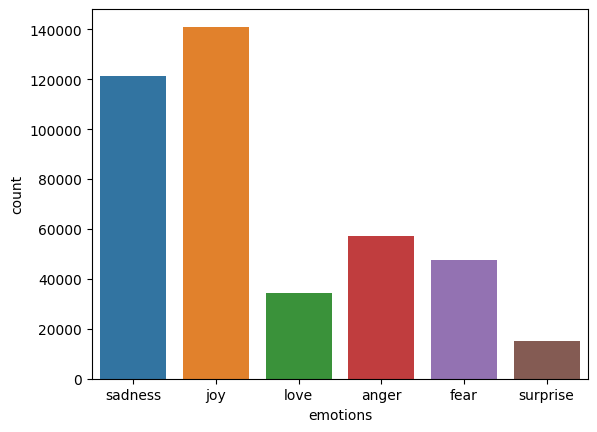

In [5]:
import seaborn as sns
sns.countplot(data = data, x = 'emotions')

In [6]:
import re
def clean_text(text):
    if isinstance(text, str):
        text = re.sub(r'[^\w\s]', '', text)
        text = text.lower()
        text = ' '.join(text.split())
        return text
    else:
        return ''

In [7]:
data['text'] = data['text'].apply(lambda x: clean_text(x))

In [8]:
x = data['text']
y = data['emotions']

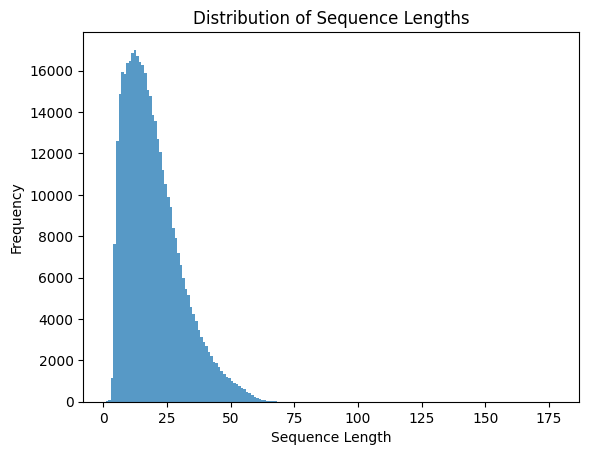

Maximum Sequence Length: 178


In [9]:
import matplotlib.pyplot as plt
sequence_lengths = [len(text.split()) for text in data['text']]
plt.hist(sequence_lengths, bins=range(min(sequence_lengths), max(sequence_lengths) + 1), alpha=0.75)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()

# Determine the maximum sequence length
max_sequence_length = max(sequence_lengths)
print("Maximum Sequence Length:", max_sequence_length)

In [10]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)


In [11]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [12]:
tokenizer = Tokenizer(num_words=None)  # num_words=None means keep all words
tokenizer.fit_on_texts(x_train)

# Get the vocabulary size
vocab_size = len(tokenizer.word_index)
print("Vocabulary Size:", vocab_size)

Vocabulary Size: 64519


In [13]:
num_words = vocab_size  # Keep all words for simplicity

# Reinitialize the Tokenizer with num_words parameter
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(x_train)

In [14]:
x_train = pad_sequences(tokenizer.texts_to_sequences(x_train), maxlen=max_sequence_length, padding='post')
x_val = pad_sequences(tokenizer.texts_to_sequences(x_val), maxlen=max_sequence_length, padding='post')
x_test = pad_sequences(tokenizer.texts_to_sequences(x_test), maxlen=max_sequence_length, padding='post')

In [15]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

In [16]:
class_names = ['sadness', 'joy', 'love', 'fear', 'anger', 'surprise']
le.transform(class_names)

array([4, 2, 3, 1, 0, 5])

In [17]:
import numpy as np
np.unique(y_train)

array([0, 1, 2, 3, 4, 5])

In [18]:
np.unique(y_val)

array([0, 1, 2, 3, 4, 5])

In [19]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout

In [20]:
model = Sequential([
    Embedding(input_dim=num_words, output_dim=100, input_length=max_sequence_length),
    Bidirectional(LSTM(200, return_sequences=True)),
    Bidirectional(LSTM(100)),
    Dropout(0.5), 
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

2024-03-25 09:16:41.359878: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-03-25 09:16:41.359944: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-03-25 09:16:41.359958: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-03-25 09:16:41.360039: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-25 09:16:41.360098: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [22]:
# Compile the model with sparse categorical crossentropy loss
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy
              metrics=['accuracy'])


In [28]:
history = model.fit(x_train, y_train, epochs = 3, validation_data = (x_val, y_val))

Epoch 1/3
9379/9379 [==============================] - 1670s 178ms/step - loss: 0.2126 - accuracy: 0.9068 - val_loss: 0.1000 - val_accuracy: 0.9382
Epoch 2/3
9379/9379 [==============================] - 1657s 177ms/step - loss: 0.1049 - accuracy: 0.9396 - val_loss: 0.0974 - val_accuracy: 0.9386
Epoch 3/3
9379/9379 [==============================] - 1602s 171ms/step - loss: 0.1001 - accuracy: 0.9414 - val_loss: 0.0931 - val_accuracy: 0.9387


In [29]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_accuracy) + 1)


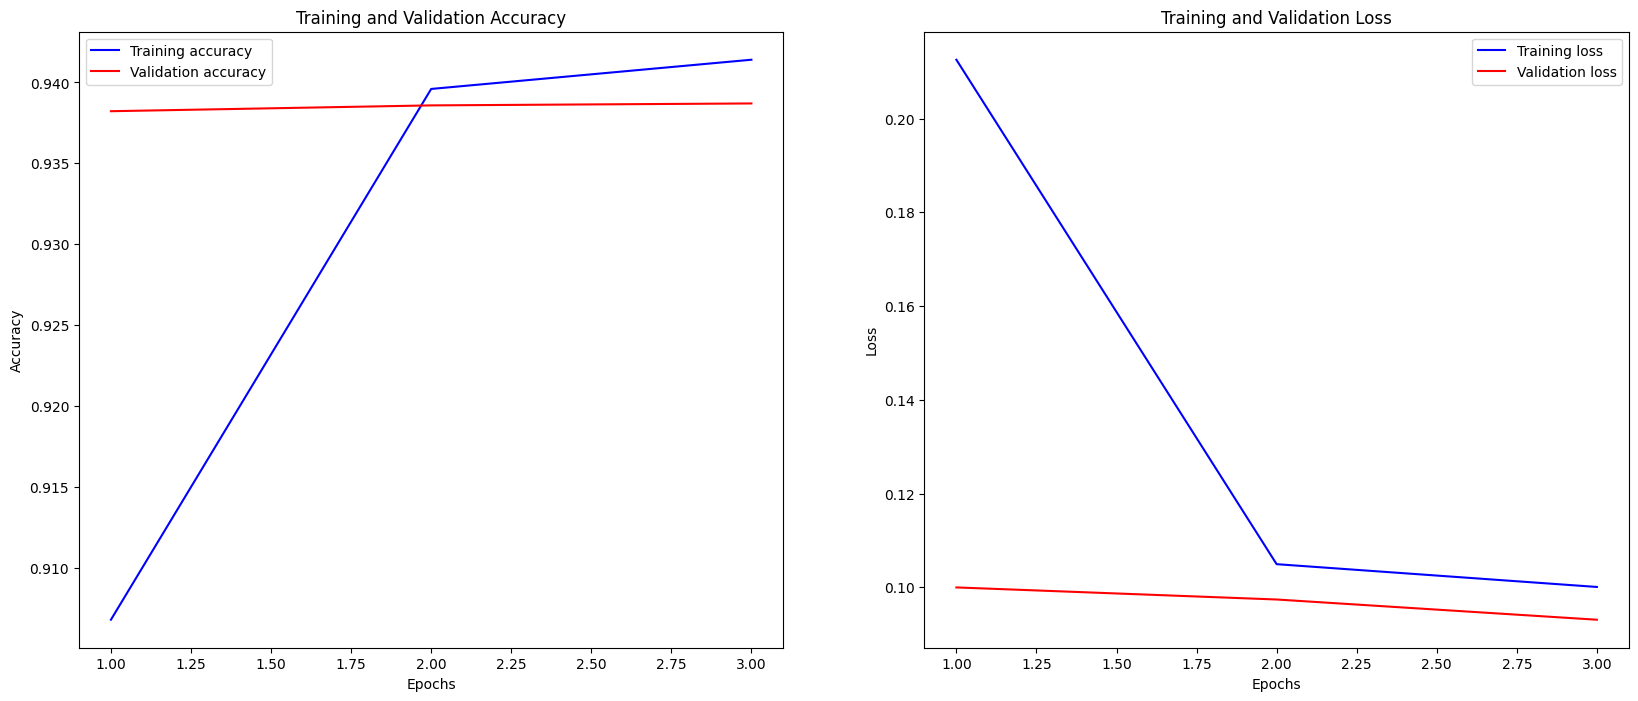

In [30]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [32]:
# from keras.models import save_model

# model.save('major_model_deep.h5')

/Users/rishavghosh/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
from keras.models import load_model

loaded_model = load_model('/Users/rishavghosh/Desktop/python/major_model_deep.h5')

In [27]:
# Evaluate the loaded model on the test data
loss, accuracy = loaded_model.evaluate(x_test, y_test)

# Print the loss and accuracy
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


2606/2606 [==============================] - 108s 41ms/step - loss: 0.0931 - accuracy: 0.9405
Test Loss: 0.0931379497051239
Test Accuracy: 0.9405244588851929


In [88]:
text = "I can't believe you did that again! It makes me so angry every time"
text = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=max_sequence_length, padding='post')

In [89]:
text

array([[  1, 329,  30, 123,   8, 125,  12, 157,  18,  14, 247, 150,  52,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0

In [90]:
pred = loaded_model.predict(text)

1/1 [==============================] - 0s 51ms/step


In [91]:
pred

array([[0.74908453, 0.11827906, 0.05394025, 0.00764583, 0.06820771,
        0.00284256]], dtype=float32)

In [92]:
classes = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']
a = np.argmax(pred)
classes[a]

'anger'